In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("./datasets/fashion-mnist_train.csv")
test_data = pd.read_csv("./datasets/fashion-mnist_test.csv")
train_data.shape, test_data.shape

((60000, 785), (10000, 785))

In [3]:
train_features = torch.tensor(train_data.iloc[:, 1:].values, dtype = torch.float32)
train_labels = torch.tensor(train_data.iloc[:,0].values, dtype = torch.int64)

test_features = torch.tensor(test_data.iloc[:, 1:].values, dtype = torch.float32 )
test_labels = torch.tensor(test_data.iloc[:,0].values, dtype = torch.int64)

train_features.shape,  train_labels.shape, test_features.shape, test_labels.shape

(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [4]:
train_dataset = TensorDataset(train_features, train_labels )
test_dataset = TensorDataset(test_features, test_labels)

In [5]:
batch_size = 64
input_size = 784
num_classes = 10
learning_rate = 3e-4
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("cuda" if torch.cuda.is_available() else "cpu")

cpu


In [6]:
train_loader = DataLoader(dataset = train_dataset, shuffle = True, batch_size = batch_size)
test_loader = DataLoader(dataset = test_dataset, shuffle = True, batch_size = batch_size)

In [7]:
class Network(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Network, self).__init__()    
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Dropout(0.5),
        )
    
    def forward(self, x):
        return self.model(x)
        

In [8]:
model = Network(input_size, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [9]:
for epoch in range(num_epochs):
    for idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)
    
        scores = model(data)
        loss = criterion(scores, targets.long())
        
        optimizer.zero_grad()
        loss.backward()

        optimizer.step()
#     scheduler.step()

In [13]:
def get_accuracy(loader, model):
    num_correct = 0
    total = 0
    model.eval()
    
    with torch.no_grad():
        for data, label in loader:
            data = data.to(device)
            label = label.to(device)
            
            scores = model(data)
            _, preds = scores.max(1)

            num_correct += (preds == label).sum()
            total += data.size(0)
        
    print(f"Accuracy : {(num_correct / total)*100:.2f}%")
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    plt.imshow(test_data.iloc[0, 1:].values.reshape((28,28)))
    print(classes[torch.argmax(model(torch.tensor(test_data.iloc[0, 1:].values, dtype = torch.float32).to(device)))])

Accuracy : 83.14%
T-shirt/top


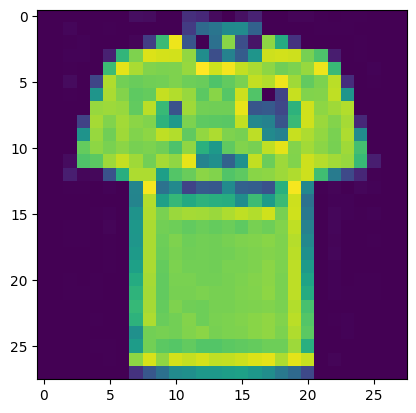

In [14]:
get_accuracy(train_loader, model)

In [12]:
torch.save(model.state_dict(), "mnistFashionModel.pt")